In [1]:
import tensorflow as tf

print(tf.__version__)
!pip install -q imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

2.1.0


In [28]:
# Train data
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

import pandas as pd
from scipy import signal
from scipy.fft import fft, ifft

def filter_signal(x):
    N = 10 
    Fc = 40
    Fs = 1600
    h = signal.firwin(numtaps=N, cutoff=40, nyq=Fs/2)
    y = signal.lfilter(h, 1.0, x)
    return y

data = []
for i in range(6):
    for j in range(9): 
        filename = 'data/rf-lab/nine_movs_six_sub_split/' + str(i + 1) + '_' + str(j + 1) + '.txt'
        x = np.load(filename, allow_pickle=True)
        x = np.array(x)
        for line in x:
            line = np.insert(line,0,[i, j])
            data.append(line)
        
df = pd.DataFrame(data)
df = df.rename(columns={0: "subject", 1: "move"})


# Фильтруем все данные
pieces = df.drop(columns=['subject','move']).values

for i in range(len(pieces)):
    pieces[i] = filter_signal(pieces[i])

filtered_df = pd.DataFrame(pieces)
filtered_df['subject'] = df['subject']
filtered_df['move'] = df['move']

mask = (filtered_df['move'] == 0) & (filtered_df['subject'] == 0)
filtered_values = filtered_df[mask].drop(columns=['subject','move']).values

print(filtered_values.max())
# filtered_values = np.abs(filtered_values)
filtered_values = filtered_values/filtered_values.max()

display.display(filtered_df)

74.48446328758249


,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,subject,move
0,0.019184,-0.117956,-0.504385,-1.417703,-2.937734,-4.586769,-5.685070,-6.069641,-6.296389,-7.074130,...,-8.422348,-8.409098,-8.536900,-8.829320,-8.676672,-7.748808,-6.566791,-5.978246,0.0,0.0
1,0.109766,0.192368,0.388706,0.513958,0.438615,0.451957,0.966088,1.917473,2.703887,2.763526,...,5.965666,6.214184,6.039100,5.389569,4.914308,5.019141,5.256442,4.987919,0.0,0.0
2,-0.013526,-0.214920,-0.668653,-1.557169,-2.699478,-3.450672,-3.228912,-2.195842,-1.171587,-0.884318,...,10.048685,10.221023,9.952214,9.408643,9.212963,9.516529,9.671185,9.083959,0.0,0.0
3,-0.219850,-0.889058,-2.484337,-5.225749,-8.568529,-11.349164,-12.612922,-12.404340,-11.660034,-11.310731,...,0.643562,1.297163,1.217244,0.662370,0.370879,0.450769,0.341035,-0.349355,0.0,0.0
4,-0.031139,-0.237518,-0.644233,-1.372980,-2.175903,-2.563013,-2.316893,-1.846487,-1.766667,-2.210454,...,-2.693337,-2.727267,-3.565216,-4.556220,-4.799043,-4.286212,-3.743031,-3.632341,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,-0.029066,-0.117191,-0.349812,-0.794492,-1.425174,-2.185004,-2.900754,-3.533980,-4.071332,-4.549576,...,-7.222252,-5.255603,-3.855187,-3.294331,-3.382001,-3.722752,-4.126938,-4.595246,5.0,8.0
2816,-0.069325,-0.199757,-0.526066,-0.942765,-1.272278,-1.251427,-0.765267,-0.027302,0.509383,0.429804,...,-6.296145,-5.815165,-5.019292,-4.010560,-2.943733,-2.032305,-1.466981,-1.504227,5.0,8.0
2817,-0.013969,-0.113277,-0.286744,-0.644808,-1.077226,-1.348137,-1.387163,-1.171165,-0.764088,-0.424928,...,-3.849866,-3.597630,-3.514349,-3.499150,-3.291547,-2.774455,-2.138335,-1.881805,5.0,8.0
2818,0.086677,0.203849,0.536951,0.997265,1.489779,2.048830,2.590274,3.070298,3.261120,3.100397,...,-8.278415,-7.892552,-7.492027,-7.115104,-6.784341,-6.275770,-5.503194,-4.583612,5.0,8.0


In [3]:
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(filtered_values).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, use_bias=False, input_shape=(400,)))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.Dense(128))
    model.add(layers.Dense(400))
    assert model.output_shape == (None, 400)

    return model

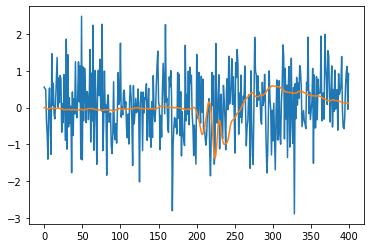

In [29]:
generator = make_generator_model()

noise = tf.random.normal([1, 400])
# noise = np.array([filtered_values[2]])
generated_image = generator(noise, training=False)

plt.plot(generated_image[0])
plt.plot(filtered_values[2])

In [8]:
def make_discriminator_model():
    model_m = tf.keras.Sequential()
    #model_m.add(Reshape((INPUT_SIZE, num_sensors), input_shape=(input_shape,)))
    num_sensors = 1 
    INPUT_SIZE = 400
    model_m.add(layers.Reshape((INPUT_SIZE, num_sensors), input_shape=(INPUT_SIZE,)))
    model_m.add(layers.Conv1D(25, 80, activation='relu', input_shape=(INPUT_SIZE,num_sensors)))
#     model_m.add(layers.Conv1D(100, 10, activation='relu', input_shape=(400,)))
    model_m.add(layers.Conv1D(100, 10, activation='relu'))
    model_m.add(layers.MaxPooling1D(3))
#     model_m.add(layers.Conv1D(160, 10, activation='relu'))
    model_m.add(layers.Conv1D(160, 10, activation='relu'))
    model_m.add(layers.GlobalAveragePooling1D())
    model_m.add(layers.Dropout(0.5))
    
    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(1))

#     model_m.add(Dense(num_classes, activation='softmax'))
#     print(model_m.summary())
    
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[400]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

    return model_m

In [9]:
discriminator = make_discriminator_model()

In [10]:
decision = discriminator(filtered_values)
print (decision)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[1.5418804 ]
 [1.3027096 ]
 [1.2872276 ]
 [1.3021683 ]
 [1.5061882 ]
 [1.3257427 ]
 [1.200127  ]
 [1.1206465 ]
 [1.5184647 ]
 [1.5031109 ]
 [1.3299186 ]
 [1.3323241 ]
 [1.2471118 ]
 [1.1736524 ]
 [1.1121365 ]
 [1.1990347 ]
 [1.1874745 ]
 [0.9886004 ]
 [0.88752675]
 [1.0704436 ]
 [1.2199979 ]
 [1.300828  ]
 [1.2149208 ]
 [0.9512658 ]
 [1.1246259 ]
 [1.0319512 ]
 [1.6159816 ]
 [1.3452806 ]
 [0.8730694 ]
 [1.0474324 ]
 [0.9883908 ]
 [0.97417045]
 [0.87582445]
 [1.1555364 ]
 [1.197252  ]
 [1.565

In [11]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.MeanSquaredError()

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

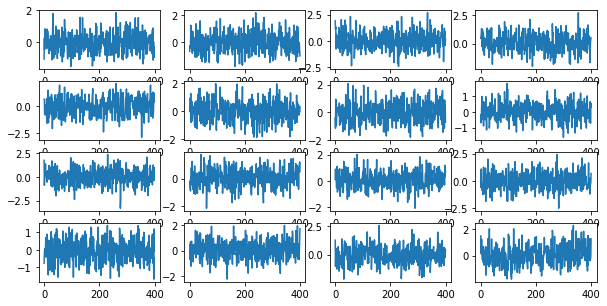

In [33]:
EPOCHS = 5
noise_dim = 400
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
#         print('gen_loss', gen_loss)
#         print('disc_loss', disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
#             print(image_batch)
            train_step(image_batch)
#         break
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,5))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.plot(predictions[i])

    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
            
train(train_dataset, EPOCHS)